In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors

import datetime
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
import copy


import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

palette = ["#a7e149","#e149a7", "#c393f4", "#d683f2", "#dd9e9e", "#fa91aa", "#fc9e9e", "#49e183", "#aa91aa", "#ff93f4"]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
df = pd.read_csv("/content/drive/MyDrive/AM/marketing_campaign.csv", sep=",")

In [78]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def summary(df):
    # Create a DataFrame with missing value information
    missing_info = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])


    # Create a DataFrame with data types
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])
    # Combine all the information into a single DataFrame
    summary_df = pd.concat([missing_info, data_types], axis=1)


    # Iterate through each column in your DataFrame
    for column in df.columns:
        # Check if the column is categorical
        if pd.api.types.is_object_dtype(df[column]):
            num_unique_choices = df[column].nunique()
            # Add the number of unique choices to the summary DataFrame
            summary_df.loc[column, 'Unique Choices'] = num_unique_choices

        if pd.api.types.is_numeric_dtype(df[column]):
            # Get the lower and upper thresholds for outliers
            low_limit, up_limit = outlier_thresholds(df, column)

            # Calculate the range (max - min) for numeric columns
            summary_df.loc[column, 'min'] = df[column].min()
            # Calculate the range (max - min) for numeric columns
            summary_df.loc[column, 'max'] = df[column].max()
            summary_df.loc[column, 'Mean'] = df[column].mean()
            # Calculate the median (50% percentile)
            summary_df.loc[column, 'Median'] = df[column].median()
            # Calculate the variance
            summary_df.loc[column, 'Variance'] = df[column].var()
            # Calculate the standard deviation
            summary_df.loc[column, 'deviation'] = df[column].std()


            # Count the number of outliers in the column
            num_outliers = len(df[(df[column] < low_limit) | (df[column] > up_limit)])
            # Add the outlier count to the summary DataFrame
            summary_df.loc[column, 'Num Outliers'] = num_outliers


    return summary_df

summary(df)

,Missing Values,Data Type,min,max,Mean,Median,Variance,deviation,Num Outliers,Unique Choices
ID,0,int64,0.0,11191.0,5592.159821,5458.5,1.054082e+07,3246.662198,0.0,NaN
Year_Birth,0,int64,1893.0,1996.0,1968.805804,1970.0,1.436179e+02,11.984069,1.0,NaN
Education,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
Marital_Status,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
Income,24,float64,1730.0,666666.0,52247.251354,51381.5,6.336838e+08,25173.076661,3.0,NaN
Kidhome,0,int64,0.0,2.0,0.444196,0.0,2.898725e-01,0.538398,0.0,NaN
Teenhome,0,int64,0.0,2.0,0.506250,0.0,2.965219e-01,0.544538,0.0,NaN
Dt_Customer,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663.0
Recency,0,int64,0.0,99.0,49.109375,49.0,8.388237e+02,28.962453,0.0,NaN
MntWines,0,int64,0.0,1493.0,303.935714,173.5,1.132978e+05,336.597393,27.0,NaN


In [79]:
print("Values of column 'Marital_Status' are:", df["Marital_Status"].unique())
print("Values of column 'Education' are:",df["Education"].unique())

Values of column 'Marital_Status' are: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
Values of column 'Education' are: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']


NOTAS:
- Conforme tabela acima, há 24 valores faltantes em 'income' e outliers;
- O atributo 'Dt_customer' não está no formato DateTime;
- Alguns atributos do dataset estão com dtype de objetos, faremos a conversão para numérico;
- Criaremos a seguir um atributo 'Monetary' com o total gasto por cada cliente, somando todas as categorias;
- Criamos um atributo 'children', que representa o total de filhos;
- Simplificamos o atributo 'Education' em menos valores possíveis.

In [80]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage"""

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of DataFrame is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


In [44]:
#To remove the NA values
df = df.dropna()

#Dt_Customer to datetime
#df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format="%d-%m-%Y")
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format="%Y-%m-%d")

#Age of customer today
df["Age"] = 2020-df["Year_Birth"]

#Deriving living situation by marital status"Alone"
df["Living_With"]=df["Marital_Status"].replace({
    "Married":"Partner","Together":"Partner","Absurd":"Alone","Widow":"Alone",
    "YOLO":"Alone","Divorced":"Alone","Single":"Alone",})

#Feature indicating total children living in the household
df["Children"]=df["Kidhome"]+df["Teenhome"]

#Feature for total members in the householde
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2})+ df["Children"]

#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
df["Frequency"]=df["NumDealsPurchases"] + df["NumWebPurchases"] + df["NumCatalogPurchases"] + df["NumStorePurchases"]

#Total spendings on various items
df["Monetary"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
#df['Monetary'] = df['Monetary'] / df['Frequency']

#Dropping some of the redundant features
del_cols = ["Marital_Status", "Z_CostContact", "Z_Revenue",
            'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response',
           "MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds",
           "NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases", 'NumWebVisitsMonth',
           "Year_Birth", "Kidhome","Teenhome"]
df =  df.drop(del_cols, axis=1)
#df = df2.drop(["Dt_Customer"], axis=1)#, "ID"

### **LIMPEZA DO DATASET**

Identificação e remoção de alguns outliers:
- Renda superior a 100000;
-  Idade superior a 80 anos;
- Gasto superior a 1200

In [45]:
numeric_columns = df.select_dtypes(include=['number']).columns

def outliers_boxplots(df, columns=numeric_columns, title="outlier Numeric Columns", color="#21908C"):
    fig = make_subplots(rows=1, cols=len(columns), subplot_titles=columns)
    for i, column in enumerate(columns):
        trace = go.Box(y=df[column],name=f'{column}',marker=dict(color=color))
        fig.add_trace(trace, row=1, col=i+1)
    fig.update_layout(title_text=title, title_x=0.5)
    fig.show()

outliers_boxplots(df, numeric_columns)

In [46]:
df = df[df.Income < 100000]
df = df[df.Age < 80]
df = df[df.Monetary < 1200]
df = df[df.Frequency < 40]

outliers_boxplots(df, numeric_columns)

In [47]:
summary(df)

,Missing Values,Data Type,min,max,Mean,Median,Variance,deviation,Num Outliers,Unique Choices
ID,0,int64,0.0,11191.0,5582.380235,5462.0,1.078608e+07,3284.216582,0.0,NaN
Education,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
Income,0,float64,1730.0,96547.0,45846.597432,44964.0,3.251474e+08,18031.844486,0.0,NaN
Dt_Customer,0,datetime64[ns],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recency,0,int64,0.0,99.0,48.652150,49.0,8.355264e+02,28.905474,0.0,NaN
Age,0,int64,24.0,77.0,50.918481,50.0,1.295554e+02,11.382239,0.0,NaN
Living_With,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
Children,0,int64,0.0,3.0,1.100503,1.0,5.005081e-01,0.707466,0.0,NaN
Family_Size,0,int64,1.0,5.0,2.753769,3.0,7.454816e-01,0.863413,0.0,NaN
Frequency,0,int64,0.0,39.0,13.321608,12.0,5.352333e+01,7.315964,0.0,NaN


### **CLUSTERIZAÇÃO DO DATASET**

In [48]:
import scipy.stats as stats
# Create a contingency table
contingency_table = pd.crosstab(df['Education'], df['Living_With'])

# Perform a chi-square test
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Display the p-value and chi-squared statistic
print(f'Chi-squared statistic: {chi2}')
print(f'P-value: {p}')

# Create a Plotly bar chart
fig = px.bar(contingency_table,
             x=contingency_table.index,
             y=contingency_table.columns,
             title=f'Chi-Square Test: P-value = {p:.4f}',
             labels={'x': 'Education', 'y': 'Living_With'},
             barmode='group')

# Show the plot
fig.show()

Chi-squared statistic: 2.011318828947375
P-value: 0.3658033392394474


In [49]:
#Get list of categorical variables
LE=LabelEncoder()
object_cols =["Education","Living_With"]
for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)
print('All features are now numerical')
df.head()

All features are now numerical


,ID,Education,Income,Dt_Customer,Recency,Age,Living_With,Children,Family_Size,Frequency,Monetary
1,2174,0,46344.0,2014-03-08,38,66,0,2,3,6,27
2,4141,0,71613.0,2013-08-21,26,55,1,0,2,21,776
3,6182,0,26646.0,2014-02-10,26,36,1,1,3,8,53
4,5324,1,58293.0,2014-01-19,94,39,1,1,3,19,422
5,7446,1,62513.0,2013-09-09,16,53,1,1,3,22,716


In [50]:
df_clustering=df[["Education","Income","Age", "Recency","Family_Size","Monetary","Frequency"]]
#Scaling
scaler = StandardScaler()
scaler.fit(df_clustering)
scaled_features = pd.DataFrame(scaler.transform(df_clustering),columns= df_clustering.columns )
print('All features are now scalled')
scaled_features.head()

All features are now scalled


,Education,Income,Age,Recency,Family_Size,Monetary,Frequency
0,-0.891976,0.027592,1.325375,-0.368620,0.285263,-0.932355,-1.001051
1,-0.891976,1.429338,0.358687,-0.783882,-0.873255,1.067115,1.049832
2,-0.891976,-1.065113,-1.311047,-0.783882,0.285263,-0.862948,-0.727600
3,0.543360,0.690438,-1.047405,1.569271,0.285263,0.122105,0.776381
4,0.543360,0.924534,0.182925,-1.129934,0.285263,0.906944,1.186558


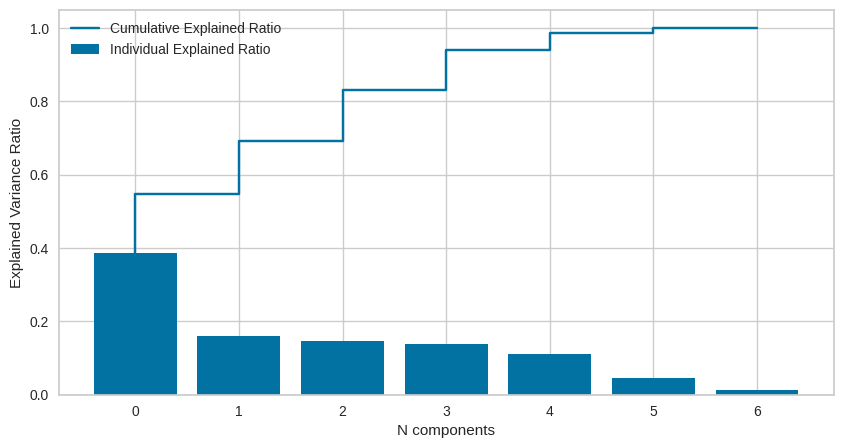

In [51]:
pca = PCA()
pca.fit(scaled_features)
cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))
plt.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, label="Individual Explained Ratio")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, label="Cumulative Explained Ratio")
plt.xlabel("N components")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc="best")
plt.show()

In [52]:
cols = ["PCA1", "PCA2", "PCA3"]
pca = PCA(n_components=len(cols))
pca.fit(scaled_features)
PCA_df = pd.DataFrame(pca.transform(scaled_features), columns=(cols))
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PCA1,1791.0,1.289371e-17,1.644252,-2.768638,-1.444655,-0.341976,1.507910,4.155794
PCA2,1791.0,-3.173837e-17,1.060736,-3.075979,-0.665775,-0.037431,0.724306,3.136918
PCA3,1791.0,-3.768931e-17,1.011464,-2.469239,-0.693173,-0.014278,0.714996,2.504693


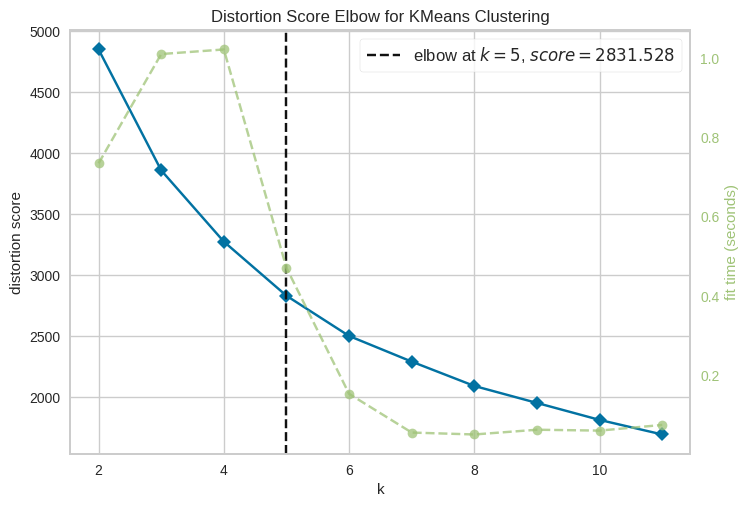

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [53]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=11)
visualizer.fit(PCA_df)        # Fit the data to the visualizer
visualizer.show()

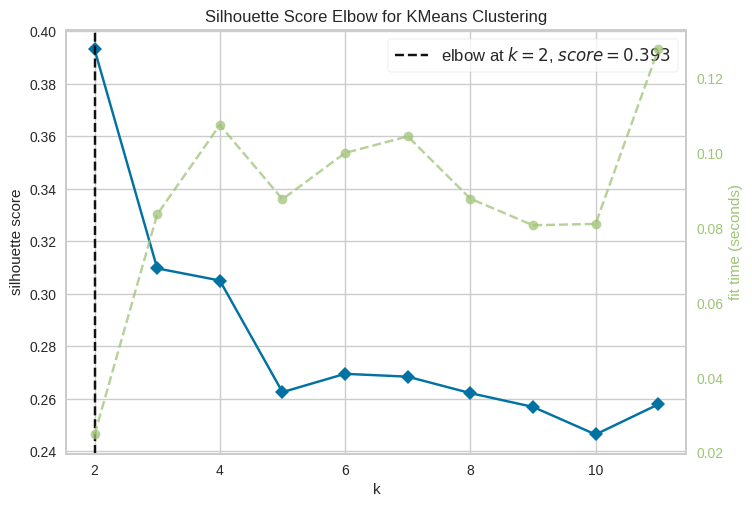

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [54]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=11, metric='silhouette')
visualizer.fit(PCA_df)        # Fit the data to the visualizer
visualizer.show()

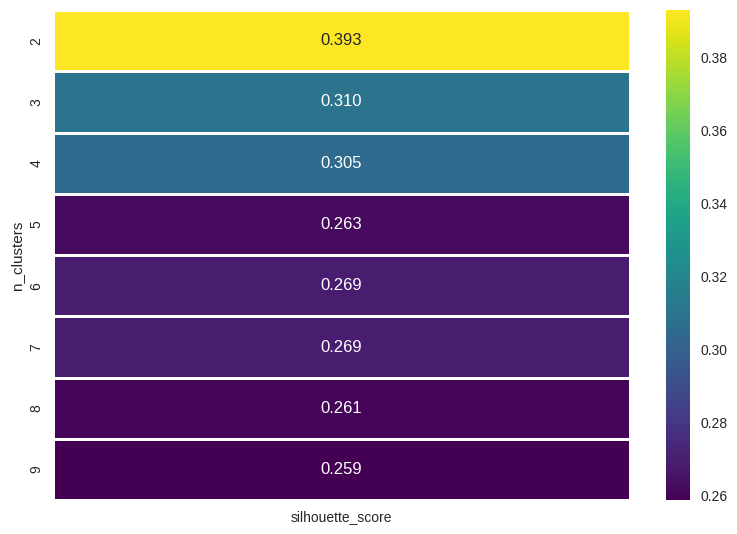

In [55]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_silhouette_layer(data):
    clusters_range = range(2, 10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='viridis')  # Mudança aqui
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(PCA_df)

In [56]:
#Initiating the Agglomerative Clustering model
nb_clusters = visualizer.elbow_value_
AC = AgglomerativeClustering(n_clusters=3)#nb_clusters

# fit model and predict clusters
AC_df = AC.fit_predict(PCA_df)
PCA_df["Clusters"] = AC_df
PCA_df["Family_Size"] = df["Family_Size"]
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= AC_df

In [ ]:
PCA_df.head()

,PCA1,PCA2,PCA3,Clusters,Family_Size
0,2.559336,-1.198603,0.255486,0,NaN
1,1.716467,0.609765,0.819844,0,1.0
2,-1.511187,-0.088509,0.573899,1,3.0
3,-1.137144,-1.675757,-0.151022,1,3.0
4,1.356180,-0.740020,-0.329865,0,2.0


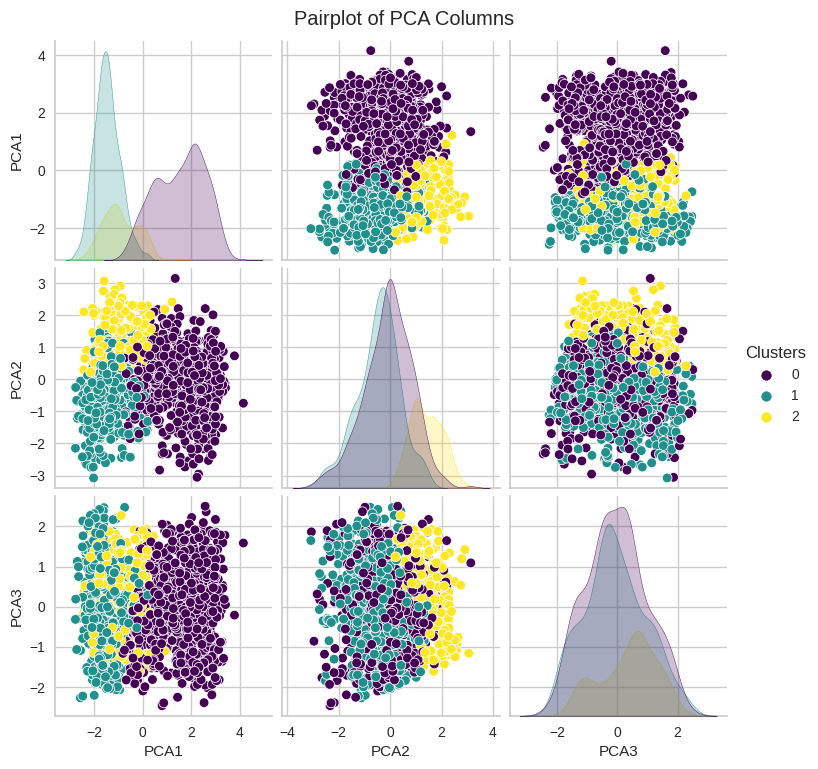

In [57]:
# Supondo que você tenha uma coluna 'Clusters' em seu DataFrame PCA_df
x = PCA_df["PCA1"]
y = PCA_df["PCA2"]
z = PCA_df["PCA3"]
c = PCA_df["Clusters"]

# Atribua manualmente três cores da paleta Viridis aos seus clusters
cluster_colors = {0: '#440154', 1: '#21908C', 2: '#FDE725'}

# Crie um trace 3D scatter
trace1 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                      marker=dict(size=6, color=c, colorscale='Viridis', colorbar=dict(title='Clusters')))

data = [trace1]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=data, layout=layout)

# Crie o pairplot com as cores definidas manualmente
sns.pairplot(data=PCA_df, vars=['PCA1', 'PCA2', 'PCA3'], hue='Clusters', palette=cluster_colors)
plt.suptitle("Pairplot of PCA Columns", y=1.02)
plt.show()

In [58]:
import plotly.express as px

# Supondo que você tenha uma coluna 'Clusters' em seu DataFrame df
fig = px.histogram(df, x="Clusters", color="Clusters",
                   color_discrete_sequence=['#440154', '#21908C', '#FDE725'], nbins=7,
                   title="Distribution Of The Clusters",
                   labels={"Clusters": "Clusters", "count": "Count"})

# Update the layout
fig.update_layout(xaxis_title="Clusters", yaxis_title="Count")

# Show the plot
fig.show()


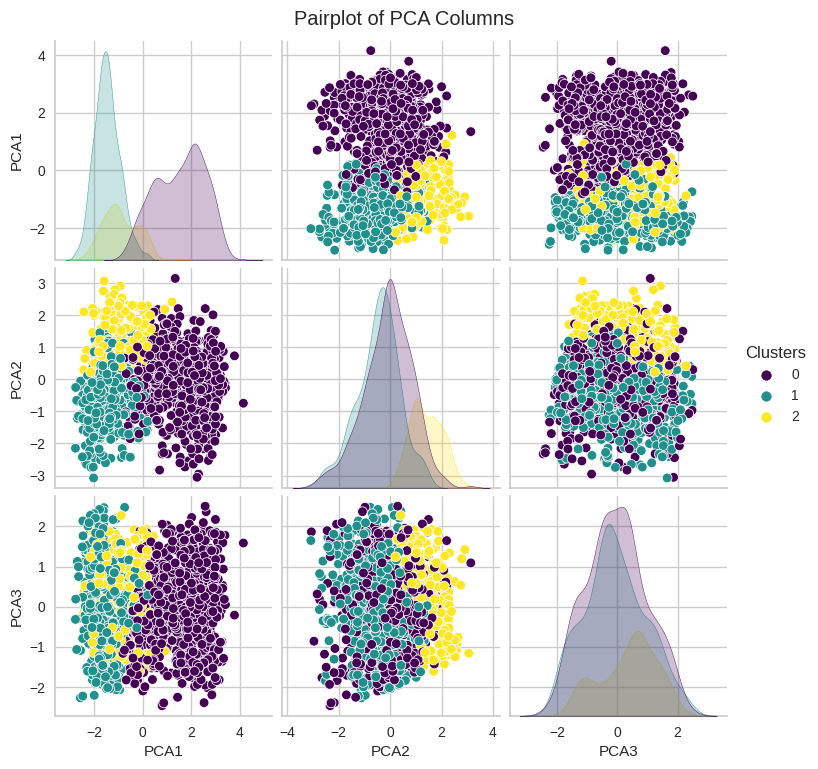

In [59]:
# Escolha o número de clusters na paleta
num_clusters = len(PCA_df['Clusters'].unique())


# Crie o pairplot com as cores definidas manualmente
sns.pairplot(data=PCA_df, vars=['PCA1', 'PCA2', 'PCA3'], hue='Clusters', palette=cluster_colors)
plt.suptitle("Pairplot of PCA Columns", y=1.02)
plt.show()


In [60]:
df.head()

,ID,Education,Income,Dt_Customer,Recency,Age,Living_With,Children,Family_Size,Frequency,Monetary,Clusters
1,2174,0,46344.0,2014-03-08,38,66,0,2,3,6,27,1
2,4141,0,71613.0,2013-08-21,26,55,1,0,2,21,776,0
3,6182,0,26646.0,2014-02-10,26,36,1,1,3,8,53,1
4,5324,1,58293.0,2014-01-19,94,39,1,1,3,19,422,0
5,7446,1,62513.0,2013-09-09,16,53,1,1,3,22,716,0


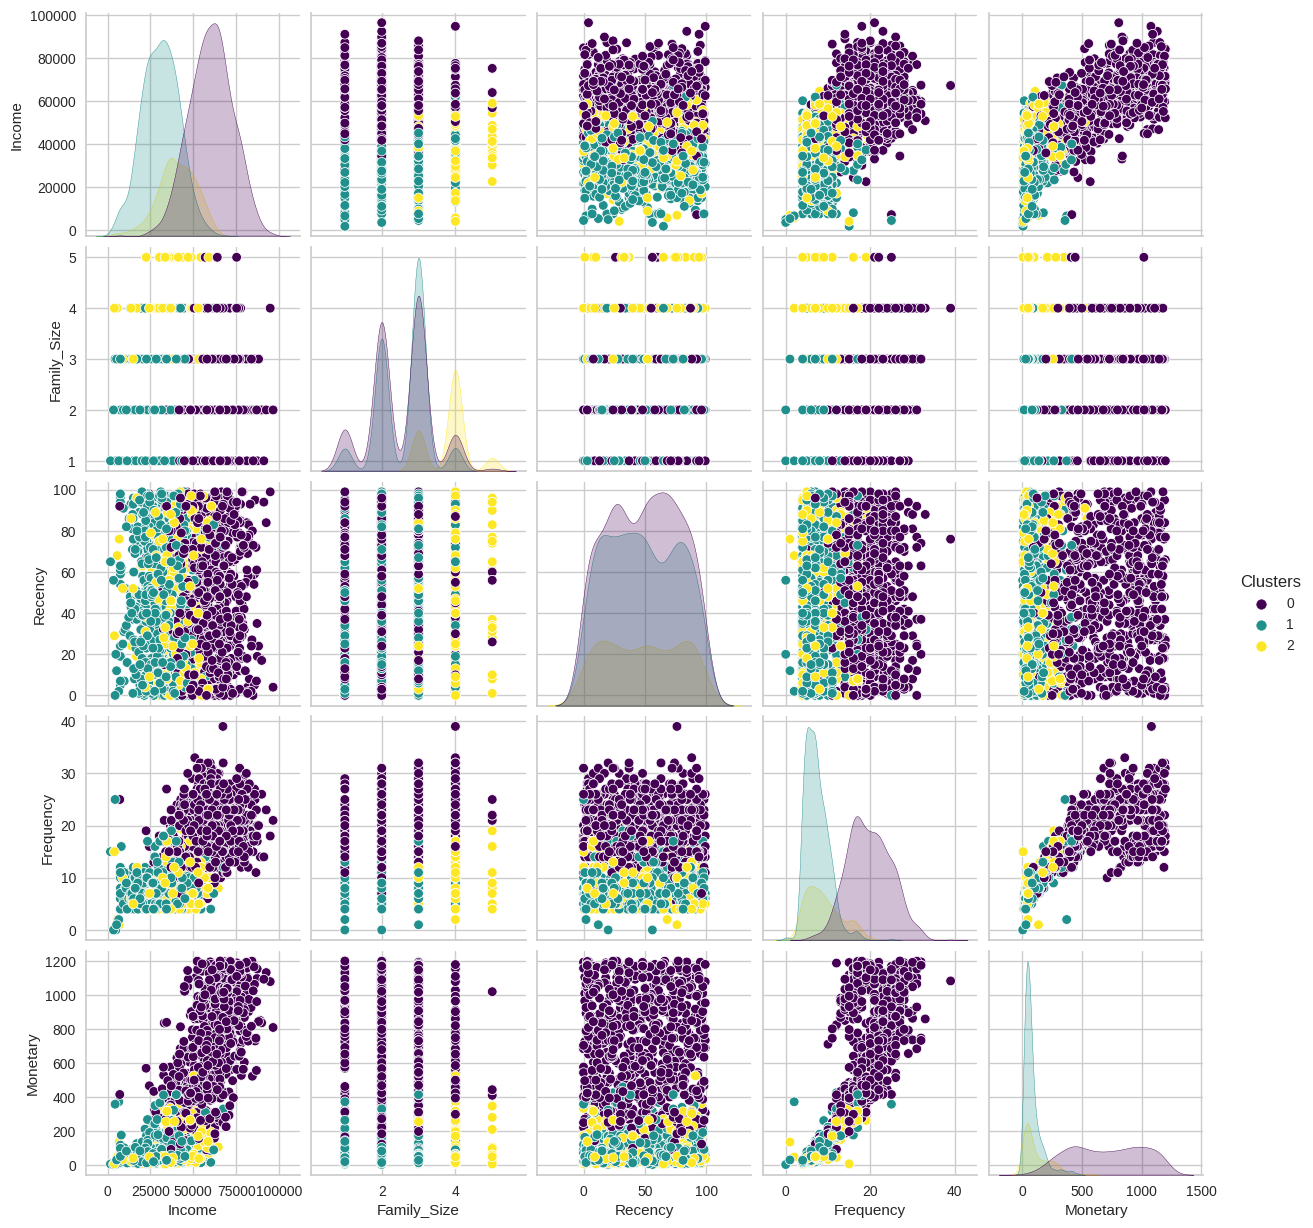

In [61]:
sns.pairplot(df[["Clusters", "Income", "Family_Size", "Recency", "Frequency", "Monetary"]],
             hue="Clusters", palette=cluster_colors)
plt.show()

In [62]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

columns = ["Income", "Age", "Family_Size", "Recency", "Frequency", "Monetary"]

# Create a subplot grid
fig = make_subplots(rows=2, cols=3, subplot_titles=[f'Clusters vs. {column}' for column in columns], horizontal_spacing=0.15)

for i, column in enumerate(columns):
    row = i // 3 + 1
    col = i % 3 + 1

    # Create a box plot for each column
    trace = go.Box(y=df[column], x=df["Clusters"], name=f'Clusters vs. {column}', )
    fig.add_trace(trace, row=row, col=col)

# Update layout
fig.update_layout(
    showlegend=False,
    height=800,
    title_text="Clusters vs. Numeric Columns",
)

# Show the plot
fig.show()

In [63]:
import plotly.express as px

# Atribua manualmente três cores da paleta Viridis aos seus clusters
cluster_colors = {0: '#440154', 1: '#21908C', 2: '#FDE725'}

# Assuming you have a DataFrame named 'df'
fig = px.scatter(df, x='Income', y='Monetary', color='Clusters',
                 size='Family_Size', color_discrete_map=cluster_colors,size_max=16, color_continuous_scale='Viridis')

fig.update_layout(
    xaxis_title='Income', yaxis_title='Total Spendings',
    xaxis=dict(title=dict(text='Income', font=dict(size=20))),
    yaxis=dict(title=dict(text='Total Spendings', font=dict(size=20))))
fig.show()

In [64]:
means = df.groupby(['Clusters']).agg({'Family_Size': 'mean',
                                                     'Income': 'mean',
                                                     'Age': 'mean',
                                                     'Recency': 'mean',
                                                     'Frequency': 'mean',
                                                     'Monetary': 'mean'})
# Calculate the count of records (rows) in each cluster
counts = df['Clusters'].value_counts().reset_index()
counts.columns = ['Clusters', 'Count']

# Merge the mean and count DataFrames
result = pd.merge(means, counts, on='Clusters')
result

,Clusters,Family_Size,Income,Age,Recency,Frequency,Monetary,Count
0,0,2.527845,60250.780872,53.943099,49.111380,19.759080,709.929782,826
1,1,2.605187,30862.327089,44.181556,48.142651,7.354467,81.391931,694
2,2,3.822878,40316.073801,58.952030,48.557196,8.981550,114.365314,271


### **ANÁLISE DO PERFIL DOS CLUSTERS**

Cluster 0 :
Total member of this cluster is 826
Compared to other clusters, they have high income and high spent.
Their Family Size is between 2 and 4 people.
Their Age is between 40 and 60 years.

Cluster 1 :
Total member of this cluster is 694
Compared to other clusters, they have low Income and low spending.
Their Family Size is between 2 and 3 people.
Their Age is between 30 and 50 years.

Cluster 2 :
Total member of this cluster is 271
Compared to other clusters, they have avg Income and avg spending
Their Family Size is between 3 and 5 people.
Their Age is between 55 and 60 years.

### **Implementação dos Modelos**